# Objective- Logistic Regression on Amazon fine food reviews (Bag of Words)

#### Codes for-
* GridSearchCV and RandomSearchCV to find optimal lambda
* l1 and l2 regularizer
* feature importance
* by increasing lambda using 'l1' regularizer, the change occurs in the result


#### About the data-
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review

In [347]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [348]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [349]:
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

In [7]:
sql=sqlite3.connect('database.sqlite')  #loading sql data
data=pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score!=3''',sql)

In [8]:
data.columns  #column names in the dataset

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [9]:
#for changing score int value to positive (1) and negative (0) i.e only in two class
def posneg(x):
    if x<3:
        return 0
    else:
        return 1
score=data['Score']
data['Score']=score.map(posneg)

In [350]:
data.head(3)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh recit car dr...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year sister late...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...


## Data cleaning

In [11]:
data=data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']] 

In [12]:
data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=True) #droping the duplicates
data.shape

(364171, 10)

In [13]:
len(data)

364171

In [14]:
import nltk
from nltk.corpus import stopwords

In [15]:
stop=set(stopwords.words('english'))

In [16]:

sno=nltk.stem.SnowballStemmer('english')  #stemmer of english language

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [17]:
#taking sample of data
#sample=data.sample(len(data))
sample_data=data.sort_values(['Time'])  #sorting data on time basis
sample_score=sample_data['Score']

In [20]:
#filtering sentence
import re
final_string=[]
s=''
for sentence in sample_data['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)
        

In [21]:
sample_data['Cleaned_text']=final_string  #creating a new column in sample_data

In [22]:
sample_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh recit car dr...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year sister late...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...


In [351]:
sample_data['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [24]:
sample_data.to_csv('sample_all_sort.csv')  #saving dataframe

In [413]:
sample_data=pd.read_csv('sample_all_sort.csv')  #retriving the sorted dataframe

In [414]:
sample_data=sample_data.iloc[:100000]  #taking initial 100k points

In [416]:
#taking the test data seperate from all other

X, x_test, y_train, y_test=train_test_split(sample_data['Cleaned_text'], sample_data['Score'], test_size=0.3) #splitting the data

In [417]:
# this function plot mse vs C plot, predicting accuracy, confusion matrix and classification report

def logistic_regression(clf, x_train, y_train, x_test, y_test):
    #plot error vs C
    x_1=[]
    x_2=[]
    y_1=[]
    y_2=[]
    for x in clf.grid_scores_:
        if(x[0]['penalty']=='l1'):
            x_1.append(x[0]['C'])
            y_1.append(1-x[1])
        else:
            x_2.append(x[0]['C'])
            y_2.append(1-x[1])
    plt.plot(x_1,y_1, label='l1')
    plt.plot(x_2,y_2, label='l2')
    plt.xlabel('value of C')
    plt.ylabel('misclassification error')
    plt.title('C vs error')
    plt.legend()
    plt.show()
    print('**********************************************************************\n')
      
    #predicting y and accuracy
    y_pred=clf.predict(x_test)
    accu=accuracy_score(y_pred,y_test)*100
    print('accuracy=',accu)
    print('**********************************************************************\n')
    
    #confusion matrix
    t=confusion_matrix(y_pred,y_test)
    print('confusion matrix--')
    #print(t)
    #print('**********************************************************************')
    sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    print('**********************************************************************\n')
    
    # finding TPR , TNR, FPR, FNR
    TNR=t[0][0]/(t[0][0]+t[1][0])
    TPR=t[1][1]/(t[0][1]+t[1][1])
    FPR=t[1][0]/(t[0][0]+t[1][0])
    FNR=t[0][1]/(t[0][1]+t[1][1])
    print('TNR=',TNR)
    print('TPR=',TPR)
    print('FPR=',FPR)
    print('FNR=',FNR)
    print('**********************************************************************\n')
    
    
    #classification report
    print(classification_report(y_pred,y_test))
    print('**********************************************************************\n')
    
    #print('ROC curve--')
    y_pred_proba=clf.predict_proba(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.plot([0,1],[0,1],linestyle='--')
    plt.legend(loc=4)
    plt.title('ROC curve')
    plt.show()
    
    return accu, auc, TNR, TPR, FPR, FNR

In [418]:
# this function takes C values and all inputs and plot the number of non zero elements in weight for every C

def sparsity(C, x_train, y_train, x_test, y_test):
    w_change=[]
    for i in C:
        clf=LogisticRegression(penalty='l1', C=i)
        clf.fit(x_train,y_train)
        accuracy=clf.predict(x_test)
        print('at C=',i)
        print('test error=',(1-accuracy_score(accuracy,y_test)))
        count=np.count_nonzero(clf.coef_)
        print('number of non zero element in w=', count)
        print('***********************************************')
        w_change.append(count)
        
        
    plt.figure(figsize=(6,6))
    plt.plot(C,w_change,color='green')
    plt.title('change in non zero element in W , when C changes')
    plt.xlabel('value of C')
    plt.ylabel('number of non zero element in W')
    plt.show()
    return w_change
        

# 1. Logistic Regression for Bag of words

###  Logistic regression for Bag of words using GridSearchCV 

In [419]:
count_vect=CountVectorizer()
x_train_bow=count_vect.fit_transform(X.values)

In [420]:
x_test_bow=count_vect.transform(x_test.values)

In [421]:
from sklearn.preprocessing import normalize

x_train_bow=normalize(x_train_bow)
x_test_bow=normalize(x_test_bow)


In [422]:
import seaborn as sns
from sklearn import metrics

In [423]:

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200], 'penalty':penalty}
clf=LogisticRegression()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [424]:
import pickle

In [425]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_bow,y_train)
#pickle.dump(clf,open('bow_unigram.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  4.2min finished


duration =  0:04:13.013249


In [426]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 5
best penalty= l2


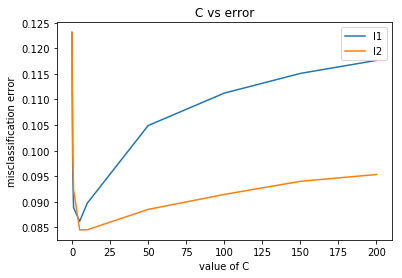

**********************************************************************

accuracy= 92.05666666666666
**********************************************************************

confusion matrix--


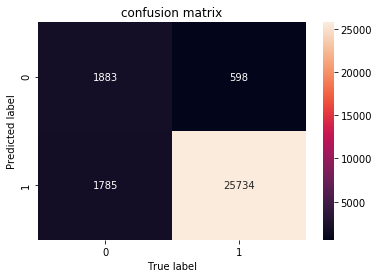

**********************************************************************

TNR= 0.5133587786259542
TPR= 0.9772899893665502
FPR= 0.4866412213740458
FNR= 0.022710010633449795
**********************************************************************

             precision    recall  f1-score   support

          0       0.51      0.76      0.61      2481
          1       0.98      0.94      0.96     27519

avg / total       0.94      0.92      0.93     30000

**********************************************************************



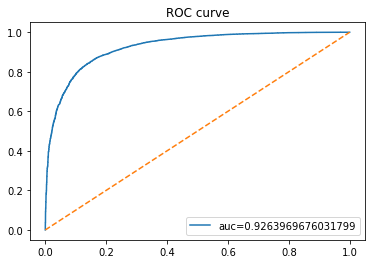

In [427]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=x_train_bow, y_train=y_train, x_test=x_test_bow, y_test=y_test)

### Logistic regression for bow, RandomizedSearchCV

In [428]:
from sklearn.model_selection import RandomizedSearchCV
tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200,500, 1000], 'penalty':penalty}
clf=LogisticRegression()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param, cv=tscv,  verbose=1)

In [429]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_bow,y_train)
#pickle.dump(clf,open('bow_unigram_balance_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.8min finished


duration =  0:02:48.344081


In [430]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 5
best penalty= l2


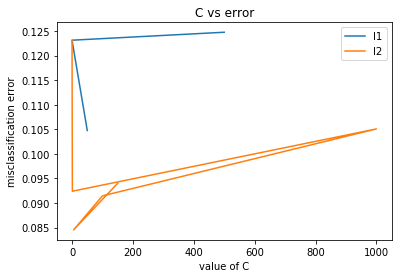

**********************************************************************

accuracy= 92.05666666666666
**********************************************************************

confusion matrix--


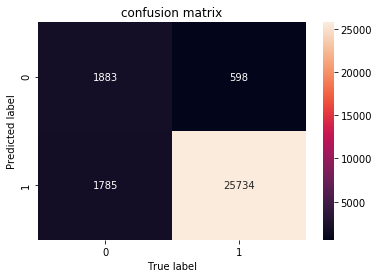

**********************************************************************

TNR= 0.5133587786259542
TPR= 0.9772899893665502
FPR= 0.4866412213740458
FNR= 0.022710010633449795
**********************************************************************

             precision    recall  f1-score   support

          0       0.51      0.76      0.61      2481
          1       0.98      0.94      0.96     27519

avg / total       0.94      0.92      0.93     30000

**********************************************************************



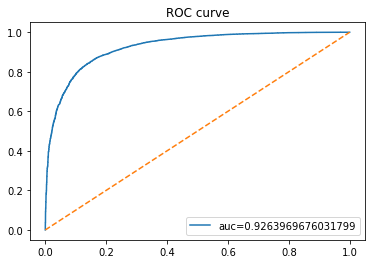

In [431]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=x_train_bow, y_train=y_train, x_test=x_test_bow, y_test=y_test)

#### Observation-
* with C=5, and penalty='l2' we get good area under curve as well as accuracy

### checking sparsity of bag of words by fixing penalty='l1' and changing C value

In [432]:
C= [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200, 500, 1000]


at C= 0.001
test error= 0.12226666666666663
number of non zero element in w= 0
***********************************************
at C= 0.005
test error= 0.12226666666666663
number of non zero element in w= 2
***********************************************
at C= 0.01
test error= 0.12226666666666663
number of non zero element in w= 8
***********************************************
at C= 0.05
test error= 0.11163333333333336
number of non zero element in w= 93
***********************************************
at C= 0.1
test error= 0.1004666666666667
number of non zero element in w= 193
***********************************************
at C= 0.5
test error= 0.08543333333333336
number of non zero element in w= 630
***********************************************
at C= 1
test error= 0.0819333333333333
number of non zero element in w= 1059
***********************************************
at C= 5
test error= 0.08120000000000005
number of non zero element in w= 3482
*************************************

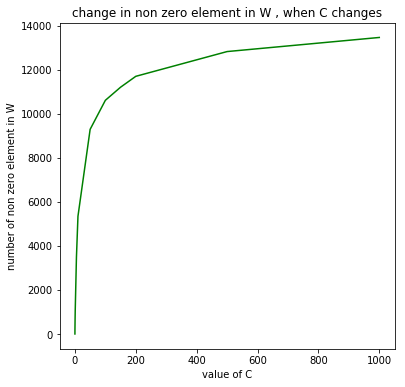

In [433]:
#calling the sparsity function
_=sparsity(C, x_train=x_train_bow, x_test=x_test_bow, y_train=y_train, y_test=y_test)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

### feature importance and multicollinearity for bag of words, using best C=5 and penalty='l2'

In [434]:
c=5
penalty='l2'

In [435]:
count_vect=CountVectorizer(ngram_range=(1,1))
x_train_bow=count_vect.fit_transform(X.values)
x_test_bow=count_vect.transform(x_test.values)

In [436]:
from sklearn.preprocessing import normalize

x_train_bow=normalize(x_train_bow)
x_test_bow=normalize(x_test_bow)


In [437]:
#computing weight before perturbation test
clf=LogisticRegression(C=c, penalty=penalty)
clf.fit(x_train_bow,y_train)
w=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 27431


In [438]:
# for findind feature importance we need to check multicollinearity
# apply perturbation test for checking multicollinearity
# in perturbation test, we add some noise to the training data and the fit the model
# the w we will get after fittng the model, if it is significantly different than w which we get without any error adding then we will say it is multicollinear

x_train_bow.data=x_train_bow.data+np.random.normal(loc=0,scale=0.1,size=x_train_bow.data.shape)  #adding a noise with a very small value

In [439]:
#computing weight after perturbation weight
clf=LogisticRegression(C=c, penalty=penalty)
clf.fit(x_train_bow,y_train)
w_=clf.coef_
print('number of non-zero element in w_=', np.count_nonzero(w_))

number of non-zero element in w_= 27431


In [440]:
#getting the number of elements in w which changes after perturbation test by more than 50%
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>50):
        cnt+=1
print('number of elements in w_delta, more than 50 %=',cnt)

number of elements in w_delta, more than 50 %= 15840


#### Observation-
* we have 27431 non zero elements in weight before perturbation and after perturbation weight
* after perturbation test, 15840 elements in weight before perturbation change by more than 50 %
* Thus we can say that half of the elements in weight are collinear


In [441]:
#code borrowed from  https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_most_informative_features(vectorizer, w, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(w[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print('top 20 words and their corresponding weights--')
    print('*****************************************************')
    print('negative class words\t\t\tpositive class words')
    print('********************\t\t\t********************')
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        


In [442]:
show_most_informative_features(count_vect,w)

top 20 words and their corresponding weights--
*****************************************************
negative class words			positive class words
********************			********************
	-14.2322	worst          		8.0237	excel          
	-9.6044	threw          		7.6344	amaz           
	-8.1723	horribl        		7.5261	delici         
	-8.1505	terribl        		7.2258	perfect        
	-8.1389	disappoint     		7.0878	awesom         
	-7.5776	return         		6.8323	uniqu          
	-7.3607	wast           		6.8172	best           
	-6.7515	aw             		6.8093	addict         
	-6.6707	stale          		6.7614	fantast        
	-6.5877	neither        		6.3656	great          
	-6.5613	weak           		6.3034	hook           
	-6.4341	cancel         		6.0751	beat           
	-6.3117	refund         		5.9038	yummi          
	-6.1537	disgust        		5.8553	pleasant       
	-6.1296	poor           		5.5366	refresh        
	-6.1199	wors           		5.5217	complaint      
	-6.0988	unpleas        		

# 2. Logistic Regression for Tf-Idf

###  Logistic regression for TfIdf using GridSearchCV 

In [443]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [444]:
x_train_tfidf=normalize(x_train_tfidf)
x_test_tfidf=normalize(x_test_tfidf)

In [445]:

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200], 'penalty':penalty}
clf=LogisticRegression()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [446]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_tfidf,y_train)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  3.6min finished


duration =  0:03:34.642598


In [447]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 5
best penalty= l2


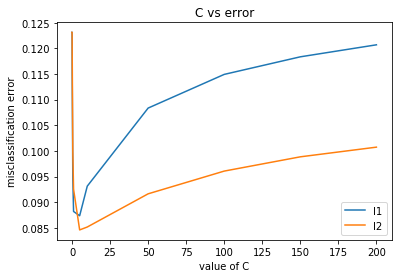

**********************************************************************

accuracy= 91.91
**********************************************************************

confusion matrix--


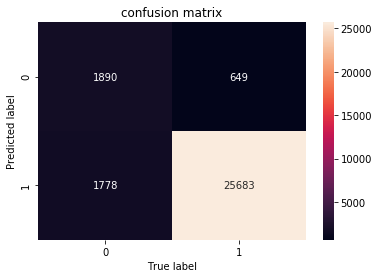

**********************************************************************

TNR= 0.5152671755725191
TPR= 0.9753531824396172
FPR= 0.4847328244274809
FNR= 0.024646817560382804
**********************************************************************

             precision    recall  f1-score   support

          0       0.52      0.74      0.61      2539
          1       0.98      0.94      0.95     27461

avg / total       0.94      0.92      0.93     30000

**********************************************************************



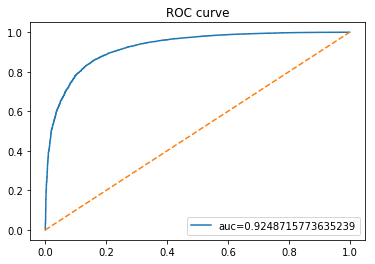

In [448]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=x_train_tfidf, y_train=y_train, x_test=x_test_tfidf, y_test=y_test)

###  Logistic regression for TfIdf using RandomizedSearchCV

In [449]:
#from sklearn.model_selection import RandomizedSearchCV
tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200], 'penalty':penalty}
clf=LogisticRegression()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param, cv=tscv,  verbose=1)

In [450]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_tfidf,y_train)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished


duration =  0:01:43.260595


In [451]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 5
best penalty= l2


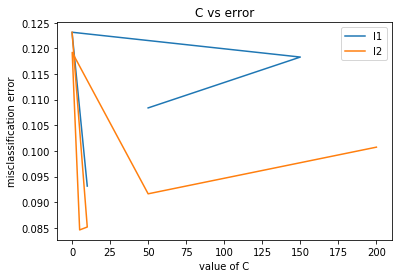

**********************************************************************

accuracy= 91.91
**********************************************************************

confusion matrix--


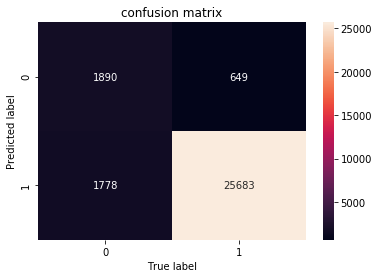

**********************************************************************

TNR= 0.5152671755725191
TPR= 0.9753531824396172
FPR= 0.4847328244274809
FNR= 0.024646817560382804
**********************************************************************

             precision    recall  f1-score   support

          0       0.52      0.74      0.61      2539
          1       0.98      0.94      0.95     27461

avg / total       0.94      0.92      0.93     30000

**********************************************************************



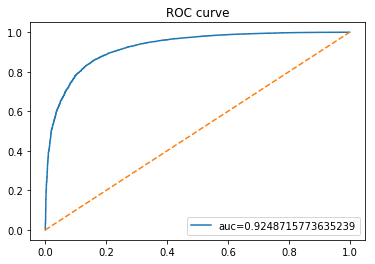

In [452]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=x_train_tfidf, y_train=y_train, x_test=x_test_tfidf, y_test=y_test)

#### Observation-
* we can choose C=5 and penalty='l2' as a best hyperparameter for Tfidf

### checking sparsity of TfIdf by fixing penalty='l1' and changing C value

In [373]:
tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [374]:
x_train_tfidf=normalize(x_train_tfidf)
x_test_tfidf=normalize(x_test_tfidf)

at C= 0.001
test error= 0.12226666666666663
number of non zero element in w= 0
***********************************************
at C= 0.005
test error= 0.12226666666666663
number of non zero element in w= 2
***********************************************
at C= 0.01
test error= 0.12226666666666663
number of non zero element in w= 8
***********************************************
at C= 0.05
test error= 0.11506666666666665
number of non zero element in w= 102
***********************************************
at C= 0.1
test error= 0.10453333333333337
number of non zero element in w= 205
***********************************************
at C= 0.5
test error= 0.08850000000000002
number of non zero element in w= 726
***********************************************
at C= 1
test error= 0.0847
number of non zero element in w= 1202
***********************************************
at C= 5
test error= 0.08206666666666662
number of non zero element in w= 4060
***********************************************

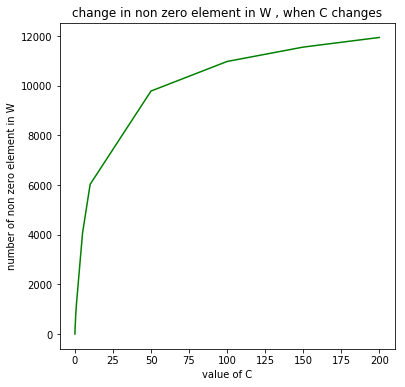

In [453]:
C= [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200]
_=sparsity(C, x_train=x_train_bow, x_test=x_test_bow, y_train=y_train, y_test=y_test)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

### feature importance and multicollinearity for TfIdf using best C=5 and penalty='l2'

In [454]:
c=5
penalty='l2'

In [455]:
clf=LogisticRegression(C=c, penalty=penalty)
clf.fit(x_train_tfidf,y_train)
w=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 27431


In [456]:
# for findind feature importance we need to check multicollinearity
# apply perturbation test for checking multicollinearity
# in perturbation test, we add some noise to the training data and the fit the model
# the w we will get after fittng the model, if it is significantly different than w which we get without any error adding then we will say it is multicollinear

x_train_tfidf.data=x_train_tfidf.data+np.random.normal(loc=0,scale=0.1,size=x_train_tfidf.data.shape)  #adding a noise with a very small value

In [457]:
clf=LogisticRegression(C=c, penalty=penalty)
clf.fit(x_train_tfidf,y_train)
w_=clf.coef_
print('number of non-zero element in w_=', np.count_nonzero(w_))

number of non-zero element in w_= 27431


In [458]:
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>50):
        cnt+=1
print('number of elements in w_delta, more than 50 %=',cnt)

number of elements in w_delta, more than 50 %= 13806


#### Observation-
* we have 27431 non zero elements in weight before perturbation and after perturbation weight
* after perturbation test, 13806 elements in weight before perturbation change by more than 50 %
* Thus we can say that more than half of the elements in weight are collinear


In [459]:
show_most_informative_features(tfidf,w)

top 20 words and their corresponding weights--
*****************************************************
negative class words			positive class words
********************			********************
	-12.6259	worst          		11.8703	great          
	-8.5127	threw          		10.4060	best           
	-7.9902	disappoint     		9.0467	delici         
	-7.1527	terribl        		8.9849	excel          
	-7.0659	return         		8.7805	perfect        
	-6.9630	horribl        		8.4685	love           
	-6.7741	wast           		7.5331	amaz           
	-5.8615	disgust        		6.8371	awesom         
	-5.7730	neither        		6.7867	nice           
	-5.6751	stale          		6.6114	favorit        
	-5.6743	aw             		6.5681	fantast        
	-5.5864	refund         		6.4263	addict         
	-5.4932	cancel         		6.1344	uniqu          
	-5.4281	horrid         		6.0408	beat           
	-5.4275	unpleas        		5.9481	hook           
	-5.4061	poor           		5.6848	pleasant       
	-5.3749	weak           

# 3. Logistic Regression for Avg word2vec

In [211]:
#url for the GoogleNews word2vec model
url="https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [213]:
#downloading the GoogleNews word2vec modelinto the cognitive class disk
import urllib
urllib.request.urlretrieve (url, "GoogleNews-vectors-negative300.bin.gz")


('GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x3ffee1df4208>)

In [98]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [99]:
#loading the GoogleNews word2vec model(able to read bin.gz file directly, no need to extract)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [460]:

#getting the list of sentences in a 'list'
i=0

list_of_sentences=[]
for sent in X.values:
    filtered_sentence=[]    
    for w in sent.split():
        #w=w.decode('utf-8')
        if (w==sent.split()[0]):
            w=w[2:]
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)

In [461]:
words=list(model.wv.vocab)
print(len(words))

3000000


In [463]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence:
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [464]:
z=list(np.unique(np.where(np.isnan(vectors))[0]))
z

[442,
 855,
 6550,
 6941,
 8428,
 12673,
 14212,
 14581,
 17277,
 25826,
 25887,
 29528,
 32691,
 33866,
 53924,
 65198,
 66333,
 67442,
 68907]

In [465]:
vectors=np.delete(vectors, z, axis=0)
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)

In [466]:
#calculating avg word2vec
x_test_word=[];
for sentence in x_test.values:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    x_test_word.append(sentence_vector)

In [467]:
#checking row containing nan value
z=list(np.unique(np.where(np.isnan(x_test_word))[0]))
z

[1941, 2939, 3346, 5880, 27000]

In [468]:
#deleting row containing nan value
x_test_word=np.delete(x_test_word, z, axis=0)
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)

In [469]:
# applying normalization on every columns

vectors=normalize(vectors)
x_test_word=normalize(x_test_word)

###  Logistic regression for avg word2vec using GridSearchCV 

In [470]:

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,1000], 'penalty':penalty}
clf=LogisticRegression()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [471]:
# fitting the model
%time
start=datetime.now()
clf.fit(vectors,y_train_word)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 26.0min finished


duration =  0:26:30.123227


In [472]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 5
best penalty= l1


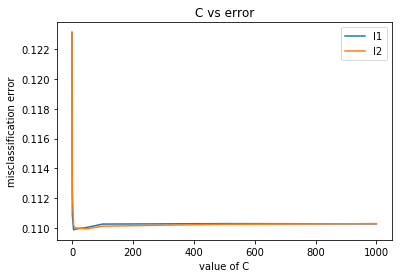

**********************************************************************

accuracy= 89.28154692448742
**********************************************************************

confusion matrix--


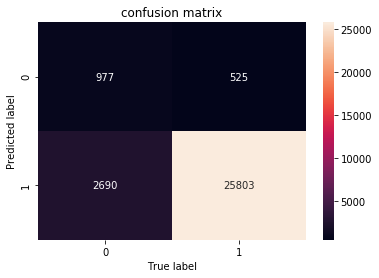

**********************************************************************

TNR= 0.2664303245159531
TPR= 0.9800592525068368
FPR= 0.733569675484047
FNR= 0.019940747493163172
**********************************************************************

             precision    recall  f1-score   support

          0       0.27      0.65      0.38      1502
          1       0.98      0.91      0.94     28493

avg / total       0.94      0.89      0.91     29995

**********************************************************************



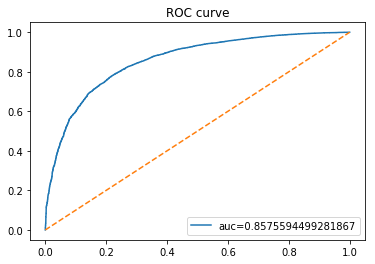

In [473]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

###  Logistic regression for avg word2vec using RandomizedSearchCV

In [474]:
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
#c=np.random.uniform(0,100,size=10)
#c=[round(x,3) for x in c]
param={'C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 50, 100, 200, 500, 1000], 'penalty':penalty}
clf=LogisticRegression()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param, cv=tscv,  verbose=1)

In [475]:
# fitting the model
%time
start=datetime.now()
clf.fit(vectors,y_train_word)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.2 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.3min finished


duration =  0:11:48.305177


In [476]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 50
best penalty= l1


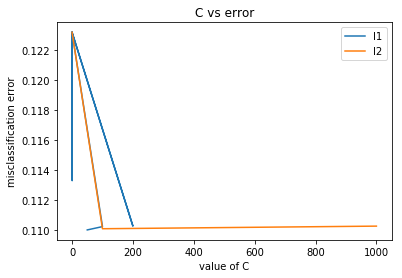

**********************************************************************

accuracy= 89.3082180363394
**********************************************************************

confusion matrix--


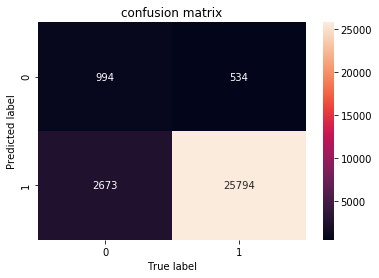

**********************************************************************

TNR= 0.27106626670302697
TPR= 0.9797174111212398
FPR= 0.728933733296973
FNR= 0.020282588878760256
**********************************************************************

             precision    recall  f1-score   support

          0       0.27      0.65      0.38      1528
          1       0.98      0.91      0.94     28467

avg / total       0.94      0.89      0.91     29995

**********************************************************************



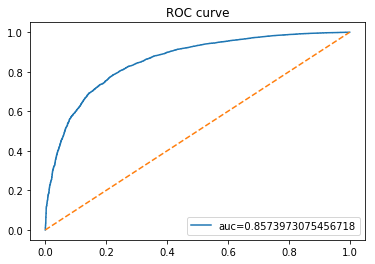

In [477]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

#### Observation-
* we can have best C=5 and best penalty=l1  as a best hyperparameter

### checking sparsity of avg word2vec by fixing penalty='l1' and changing C value

at C= 1e-05
test error= 0.8777462910485081
number of non zero element in w= 0
***********************************************
at C= 0.0001
test error= 0.1222537089514919
number of non zero element in w= 0
***********************************************
at C= 0.0005
test error= 0.1222537089514919
number of non zero element in w= 0
***********************************************
at C= 0.001
test error= 0.1222537089514919
number of non zero element in w= 0
***********************************************
at C= 0.005
test error= 0.1222537089514919
number of non zero element in w= 0
***********************************************
at C= 0.01
test error= 0.1222537089514919
number of non zero element in w= 6
***********************************************
at C= 0.05
test error= 0.11878646441073515
number of non zero element in w= 68
***********************************************
at C= 0.1
test error= 0.11431905317552926
number of non zero element in w= 122
*************************************

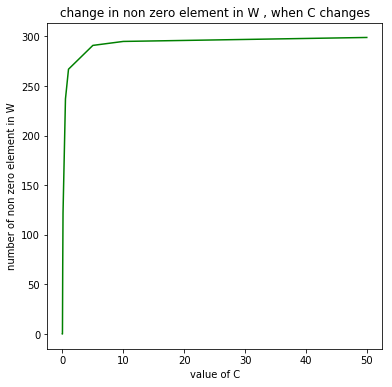

In [478]:
C= [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,5,10,50]
_=sparsity(C, x_train=vectors, x_test=x_test_word, y_train=y_train_word, y_test=y_test_word)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

### feature importance and multicollinearity for avg word2vec using the best C=5 and penalty='l1'

In [479]:
clf=LogisticRegression(C=5, penalty='l1')
clf.fit(vectors,y_train_word)
w=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 291


In [480]:
# for findind feature importance we need to check multicollinearity
# apply perturbation test for checking multicollinearity
# in perturbation test, we add some noise to the training data and the fit the model
# the w we will get after fittng the model, if it is significantly different than w which we get without any error adding then we will say it is multicollinear

vectors.data=vectors.data+np.random.normal(loc=0,scale=0.1,size=vectors.data.shape)  #adding a noise with a very small value

In [482]:
clf=LogisticRegression(C=5, penalty='l1')
clf.fit(vectors,y_train_word)
w_=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w_))

number of non-zero element in w= 299


In [483]:
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>50):
        cnt+=1
print('number of elements in w_delta, more than 50 %=',cnt)

number of elements in w_delta, more than 50 %= 284


In [484]:
print('top 10 elements of weight--')
print('******************************')
np.sort(w[0])[-10:]

top 10 elements of weight--
******************************


array([4.65127493, 4.66369606, 4.92283746, 4.92500915, 4.99378627,
       5.23350204, 5.90100258, 5.96195203, 6.86007203, 8.32286503])

#### Observation-
* only 284 in 300 elements having change more than 50 %, we may not put in collinear category
* we can't find the important words in avg word2vec

# 4. Logistic Regression for TfIdf word2vec

In [485]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [486]:
features=tfidf.get_feature_names()
len(features)
#features

27431

In [487]:
features=tfidf.get_feature_names()
len(features)
#features

27431

In [521]:
#calculating tf-idf w2vec
tfidf_vectors = []; 
row=0;
for sentence in list_of_sentences: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = model.wv[word]
            tf_idf = x_train_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1

In [522]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
z

[442,
 855,
 6550,
 6941,
 8428,
 12673,
 14212,
 14581,
 17277,
 25826,
 25887,
 29528,
 32691,
 33866,
 53924,
 65198,
 66333,
 67442,
 68907]

In [523]:

y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)
tfidf_vectors=np.delete(tfidf_vectors, z, axis=0)



In [524]:
#calculating tf-idf w2vec
x_test_tf_word = []; 
row=0;
for sentence in x_test.values: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec = model.wv[word]
            tf_idf = x_test_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    x_test_tf_word.append(sentence_vec)
    row += 1

In [525]:
z=list(np.unique(np.where(np.isnan(x_test_tf_word))[0]))
z

[1941, 2939, 3346, 5880, 27000]

In [526]:
x_test_tf_word=np.delete(x_test_tf_word, z , axis=0)
len(x_test_tf_word)

29995

In [527]:
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)
len(x_test_word)

29995

In [528]:

tfidf_vectors=normalize(tfidf_vectors)
x_test_tf_word=normalize(x_test_tf_word)

###  Logistic regression for TfIdf word2vec using GridSearchCV

In [507]:

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,1000], 'penalty':penalty}
clf=LogisticRegression()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [508]:
# fitting the model
%time
start=datetime.now()
clf.fit(tfidf_vectors,y_train_word)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 21.3min finished


duration =  0:21:40.582714


In [509]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 5
best penalty= l1


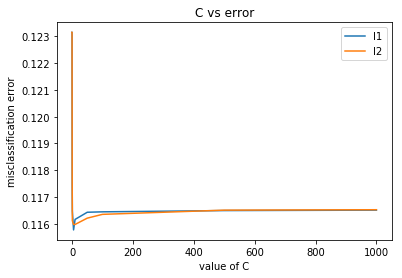

**********************************************************************

accuracy= 88.92148691448575
**********************************************************************

confusion matrix--


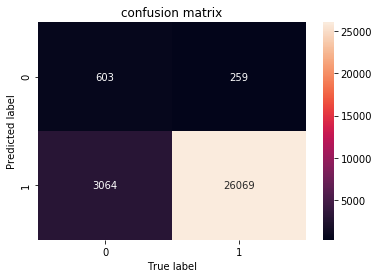

**********************************************************************

TNR= 0.16443959640032724
TPR= 0.9901625645700395
FPR= 0.8355604035996728
FNR= 0.009837435429960498
**********************************************************************

             precision    recall  f1-score   support

          0       0.16      0.70      0.27       862
          1       0.99      0.89      0.94     29133

avg / total       0.97      0.89      0.92     29995

**********************************************************************



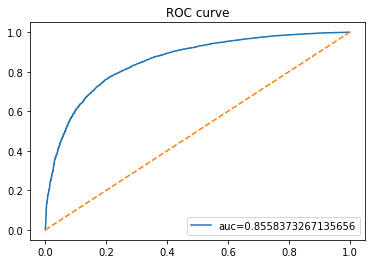

In [510]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=tfidf_vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

###  Logistic regression for TfIdf word2vec using RandomizedSearchCV

In [529]:
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
#c=np.random.uniform(0,100,size=10)
#c=[round(x,3) for x in c]
param={'C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 50, 100, 200, 500, 1000], 'penalty':penalty}
clf=LogisticRegression()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param, cv=tscv,  verbose=1)

In [530]:
# fitting the model
%time
start=datetime.now()
clf.fit(tfidf_vectors,y_train_word)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.5 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.9min finished


duration =  0:05:16.340060


In [531]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 5
best penalty= l1


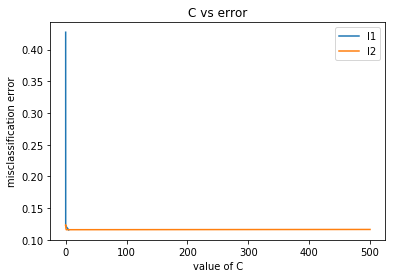

**********************************************************************

accuracy= 88.92148691448575
**********************************************************************

confusion matrix--


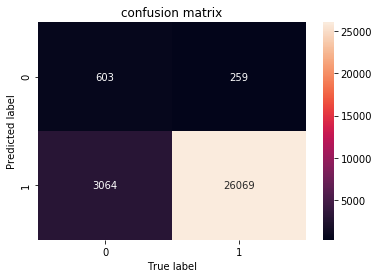

**********************************************************************

TNR= 0.16443959640032724
TPR= 0.9901625645700395
FPR= 0.8355604035996728
FNR= 0.009837435429960498
**********************************************************************

             precision    recall  f1-score   support

          0       0.16      0.70      0.27       862
          1       0.99      0.89      0.94     29133

avg / total       0.97      0.89      0.92     29995

**********************************************************************



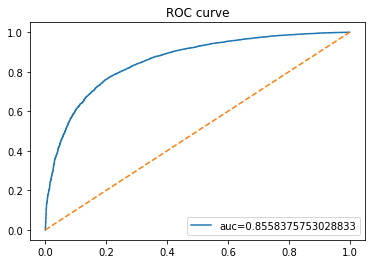

In [532]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=tfidf_vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

#### Observation-
* we can choose C=0.005 and  penalty='l2' as a best hyperparameter for Tfidf word2vec

### checking sparsity of TfIdf word2vec by fixing penalty='l1' and changing C value

at C= 1e-05
test error= 0.8777462910485081
number of non zero element in w= 0
***********************************************
at C= 0.0001
test error= 0.1222537089514919
number of non zero element in w= 0
***********************************************
at C= 0.0005
test error= 0.1222537089514919
number of non zero element in w= 0
***********************************************
at C= 0.001
test error= 0.1222537089514919
number of non zero element in w= 0
***********************************************
at C= 0.005
test error= 0.1222537089514919
number of non zero element in w= 0
***********************************************
at C= 0.01
test error= 0.1222537089514919
number of non zero element in w= 2
***********************************************
at C= 0.05
test error= 0.12098683113852304
number of non zero element in w= 79
***********************************************
at C= 0.1
test error= 0.11685280880146687
number of non zero element in w= 132
*************************************

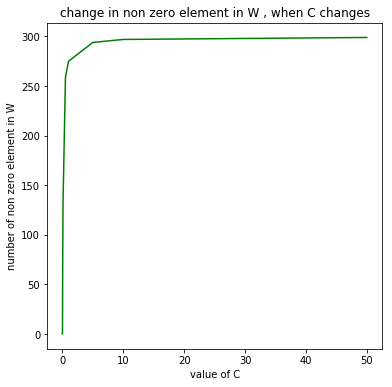

In [511]:
C= [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]
_=sparsity(C, x_train=tfidf_vectors, x_test=x_test_tf_word, y_train=y_train_word, y_test=y_test_word)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

### feature importance and multicollinearity for avg word2vec using the best C=0.005 and penalty='l2'

In [512]:
clf=LogisticRegression(C=0.005, penalty='l2')
clf.fit(tfidf_vectors,y_train_word)
w=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 300


In [513]:
# for findind feature importance we need to check multicollinearity
# apply perturbation test for checking multicollinearity
# in perturbation test, we add some noise to the training data and the fit the model
# the w we will get after fittng the model, if it is significantly different than w which we get without any error adding then we will say it is multicollinear

tfidf_vectors.data=tfidf_vectors.data+np.random.normal(loc=0,scale=0.1,size=tfidf_vectors.data.shape)  #adding a noise with a very small value

In [514]:
clf=LogisticRegression(C=0.005, penalty='l2')
clf.fit(tfidf_vectors,y_train_word)
w_=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w_))

number of non-zero element in w= 300


In [515]:
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>50):
        cnt+=1
print('number of elements in w_delta, more than 50 %=',cnt)

number of elements in w_delta, more than 50 %= 71


In [516]:
print('top 10 elements of weight--')
print('******************************')
np.sort(w)[0][-10:]

top 10 elements of weight--
******************************


array([0.2575855 , 0.26723612, 0.2898365 , 0.31176242, 0.33825084,
       0.34271317, 0.34814893, 0.35371658, 0.36860419, 0.38407761])

#### Observation-
* only 71 in 300 elements having change more than 50 %, we may not put in collinear category
* we can't find the important words in TfIdf word2vec

In [13]:
print('Final Table')

Final Table


| sno 	| featurization  	| cv algo            	| best C 	| best penalty 	| accuracy 	| AUC    	| TNR    	| TPR    	| f1-score 	|
|-----	|----------------	|--------------------	|--------	|--------------	|----------	|--------	|--------	|--------	|----------	|
| 3   	| Bag of words   	| GridSearchCV       	| 5      	| l2           	| 92.0566  	| 0.9263 	| 0.5133 	| 0.9772 	| 0.93     	|
| 4   	| Bag of words   	| RandomizedSearchCV 	| 5      	| l2           	| 92.0566  	| 0.9263 	| 0.5133 	| 0.9772 	| 0.93     	|
| 7   	| Tfidf          	| GridSearchCV       	| 5      	| l2           	| 91.91    	| 0.9248 	| 0.5152 	| 0.9753 	| 0.93     	|
| 8   	| Tfidf          	| RandomizedSearchCV 	| 5      	| l2           	| 91.91    	| 0.9248 	| 0.5152 	| 0.9753 	| 0.93     	|
| 11  	| Avg word2vec   	| GridSearchCV       	| 5      	| l1           	| 89.2815  	| 0.8575 	| 0.2664 	| 0.9800 	| 0.91     	|
| 12  	| Avg word2vec   	| RandomizedSearchCV 	| 50     	| l1           	| 89.3082  	| 0.8573 	| 0.2710 	| 0.9797 	| 0.91     	|
| 15  	| Tfidf Word2Vec 	| GridSearchCV       	| 5      	| l1           	| 88.9214  	| 0.8558 	| 0.1644 	| 0.9901 	| 0.92     	|
| 16  	| Tfidf Word2Vec 	| RandomizedSearchCV 	| 5      	| l1           	| 88.9214  	| 0.8558 	| 0.1644 	| 0.9901 	| 0.92     	|

# Conclusion-
* we have taken amazon fine food review and applied logistic regression model using BoW, Tfidf, Avg word2vec and Tfidf word2vec.
* the AUC comes for tfidf and bag of words is fairly good.
* in the final table we can see that Logistic regression works well for BOW and TFIDF, but not good in case of avg word2vec and tfidf word2vec.
* we can conclude that logistic regression works fairly well if dimension is high